In [1]:
%matplotlib widget
from pathlib import Path
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib as mpl
from tqdm.auto import tqdm
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from sklearn.cluster import KMeans
import utils
import sys
import os
import numpy as np
from environment import CONTEXTS_LABELS
#from agent import neural_network
import seaborn as sns
from agent import DQN
import pandas as pd
from scipy.spatial.distance import pdist
from environment import DuplicatedCoordsEnv
import math

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
save_path = Path("save")
save_path.exists()

True

## Data Folder

In [4]:
data_dir = save_path / "6-24-EW"
data_dir.exists()

True

In [5]:
data_path = data_dir / "data.tar"
data_path.exists()

True

In [8]:
data_dict = torch.load(data_path, weights_only=False, map_location=DEVICE)
data_dict.keys()

dict_keys(['rewards', 'steps', 'episodes', 'all_states', 'all_actions', 'all_qvalues', 'losses', 'p', 'epsilons', 'weights_val_stats', 'biases_val_stats', 'weights_grad_stats', 'biases_grad_stats', 'net', 'env', 'weights', 'biases'])

In [9]:
data_dict['all_states'][0][0][1]

tensor([ 1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  3.0000e+00,
        -1.0000e+00,  4.3711e-08,  3.0000e+00,  1.0000e+00,  1.0000e+00,
        -4.3711e-08,  3.1623e+00,  3.1623e-01,  9.4868e-01, -3.1623e-01,
         9.4868e-01,  3.1623e+00,  9.4868e-01,  3.1623e-01,  9.4868e-01,
        -3.1623e-01])

In [10]:
def conv_north_cartesian2orig(coords_orig):
        """Convert Cartesian coords from North port to origin (0, 0) coords."""
        new_x = -coords_orig[0] + 2
        new_y = -coords_orig[1] + 2

        # cos and sin are switch beacuse `direction_orig` is taken from the north port
        sin_dir = -coords_orig[2]
        cos_dir = -coords_orig[3]
        new_direction = torch.atan2(input=sin_dir, other=cos_dir) * 180 / math.pi
        new_direction = new_direction % 360
        # if 0 <= direction < 270:
        #     new_direction = 270 - direction
        # elif 270 <= direction < 360:
        #     new_direction = 270 + 360 - direction
        # else:
        #     raise ValueError("Impossible angular value")
        # new_direction = (
        #     0 if new_direction == 360 else new_direction
        # )
        return [new_x, new_y, new_direction]

In [11]:
all_states = data_dict['all_states']
run = 0
run_states = all_states[run]
episode = run_states[0]
i = 0
all_agent_orig_state = []
for step in episode:
    # print(f'STEP {i}')
    agent_full_state = step
    agent_north_cart = [agent_full_state[3], agent_full_state[4], agent_full_state[5], agent_full_state[6]]
    agent_orig_state = conv_north_cartesian2orig(coords_orig=agent_north_cart)
    # print(agent_orig_state)
    # print(agent_full_state)
    all_agent_orig_state.append(agent_orig_state)
    i += 1
print(all_agent_orig_state)


[[tensor(1.), tensor(-1.), tensor(0.)], [tensor(1.), tensor(-1.), tensor(90.)], [tensor(1.), tensor(-2.), tensor(180.0000)], [tensor(0.), tensor(-2.), tensor(270.0000)], [tensor(0.), tensor(-1.), tensor(0.)], [tensor(-1.), tensor(-1.), tensor(270.0000)], [tensor(-1.), tensor(-2.), tensor(180.0000)], [tensor(0.), tensor(-2.), tensor(90.)], [tensor(0.), tensor(-2.), tensor(180.0000)], [tensor(1.), tensor(-2.), tensor(90.)], [tensor(1.), tensor(-1.), tensor(0.)], [tensor(0.), tensor(-1.), tensor(270.0000)], [tensor(-1.), tensor(-1.), tensor(270.0000)], [tensor(-1.), tensor(-2.), tensor(180.0000)], [tensor(-2.), tensor(-2.), tensor(270.0000)], [tensor(-2.), tensor(-2.), tensor(180.0000)], [tensor(-2.), tensor(-2.), tensor(180.0000)], [tensor(-2.), tensor(-2.), tensor(270.0000)], [tensor(-2.), tensor(-1.), tensor(0.)], [tensor(-1.), tensor(-1.), tensor(90.)], [tensor(0.), tensor(-1.), tensor(90.)], [tensor(0.), tensor(-2.), tensor(180.0000)], [tensor(-1.), tensor(-2.), tensor(270.0000)], [t

In [12]:
states = [{"x": s[0].item(), "y": s[1].item(), "head": s[2].item()} for s in all_agent_orig_state]
print(states)

[{'x': 1.0, 'y': -1.0, 'head': 0.0}, {'x': 1.0, 'y': -1.0, 'head': 90.0}, {'x': 1.0, 'y': -2.0, 'head': 180.00001525878906}, {'x': 0.0, 'y': -2.0, 'head': 270.0000305175781}, {'x': 0.0, 'y': -1.0, 'head': 0.0}, {'x': -1.0, 'y': -1.0, 'head': 270.0000305175781}, {'x': -1.0, 'y': -2.0, 'head': 180.00001525878906}, {'x': 0.0, 'y': -2.0, 'head': 90.0}, {'x': 0.0, 'y': -2.0, 'head': 180.00001525878906}, {'x': 1.0, 'y': -2.0, 'head': 90.0}, {'x': 1.0, 'y': -1.0, 'head': 0.0}, {'x': 0.0, 'y': -1.0, 'head': 270.0000305175781}, {'x': -1.0, 'y': -1.0, 'head': 270.0000305175781}, {'x': -1.0, 'y': -2.0, 'head': 180.00001525878906}, {'x': -2.0, 'y': -2.0, 'head': 270.0000305175781}, {'x': -2.0, 'y': -2.0, 'head': 180.00001525878906}, {'x': -2.0, 'y': -2.0, 'head': 180.00001525878906}, {'x': -2.0, 'y': -2.0, 'head': 270.0000305175781}, {'x': -2.0, 'y': -1.0, 'head': 0.0}, {'x': -1.0, 'y': -1.0, 'head': 90.0}, {'x': 0.0, 'y': -1.0, 'head': 90.0}, {'x': 0.0, 'y': -2.0, 'head': 180.00001525878906}, {'x

In [13]:
def degrees_to_cardinal(degree):
    # Normalize the degree to [0, 360)
    degree = degree % 360

    # Define the mapping
    directions = {
        0: 'N',
        90: 'E',
        180: 'S',
        270: 'W'
    }

    # Find the closest cardinal angle
    closest = min(directions.keys(), key=lambda x: abs(x - degree))
    return directions[closest]

In [14]:
for state in states:
    deg = state["head"]
    state["head"] = degrees_to_cardinal(deg)

In [15]:
print(states)

[{'x': 1.0, 'y': -1.0, 'head': 'N'}, {'x': 1.0, 'y': -1.0, 'head': 'E'}, {'x': 1.0, 'y': -2.0, 'head': 'S'}, {'x': 0.0, 'y': -2.0, 'head': 'W'}, {'x': 0.0, 'y': -1.0, 'head': 'N'}, {'x': -1.0, 'y': -1.0, 'head': 'W'}, {'x': -1.0, 'y': -2.0, 'head': 'S'}, {'x': 0.0, 'y': -2.0, 'head': 'E'}, {'x': 0.0, 'y': -2.0, 'head': 'S'}, {'x': 1.0, 'y': -2.0, 'head': 'E'}, {'x': 1.0, 'y': -1.0, 'head': 'N'}, {'x': 0.0, 'y': -1.0, 'head': 'W'}, {'x': -1.0, 'y': -1.0, 'head': 'W'}, {'x': -1.0, 'y': -2.0, 'head': 'S'}, {'x': -2.0, 'y': -2.0, 'head': 'W'}, {'x': -2.0, 'y': -2.0, 'head': 'S'}, {'x': -2.0, 'y': -2.0, 'head': 'S'}, {'x': -2.0, 'y': -2.0, 'head': 'W'}, {'x': -2.0, 'y': -1.0, 'head': 'N'}, {'x': -1.0, 'y': -1.0, 'head': 'E'}, {'x': 0.0, 'y': -1.0, 'head': 'E'}, {'x': 0.0, 'y': -2.0, 'head': 'S'}, {'x': -1.0, 'y': -2.0, 'head': 'W'}, {'x': -1.0, 'y': -1.0, 'head': 'N'}, {'x': -2.0, 'y': -1.0, 'head': 'W'}, {'x': -2.0, 'y': -1.0, 'head': 'W'}, {'x': -2.0, 'y': -2.0, 'head': 'S'}, {'x': -1.0, 

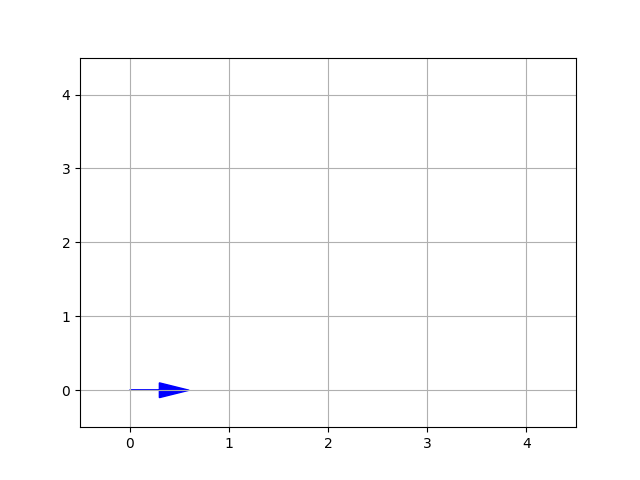

In [29]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Dummy data
arrow_dict = {'N': (0, 1), 'E': (1, 0), 'S': (0, -1), 'W': (-1, 0)}

fig, ax = plt.subplots()
ax.set_xlim(-0.5, 4.5)
ax.set_ylim(-0.5, 4.5)
ax.set_xticks(range(5))
ax.set_yticks(range(5))
ax.grid(True)

# Initial arrow
arrow = ax.arrow(0, 0, 0.3, 0, head_width=0.2, color='blue')

def update(frame):
    state = states[frame]
    dx, dy = arrow_dict[state['head']]
    arrow.remove()  # Remove old arrow
    new_arrow = ax.arrow(state['x'], state['y'], dx*0.3, dy*0.3, head_width=0.2, color='blue')
    return new_arrow,

ani = FuncAnimation(fig, update, frames=len(states), blit=True, interval=200)


In [30]:
ani.save("figures/agent_learning.mp4", writer="ffmpeg", fps=10)

MovieWriter ffmpeg unavailable; using Pillow instead.


IndexError: list index out of range

ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x3167e0da0>>
Traceback (most recent call last):
  File "/Users/juanmendez/fleischmann-research/RL_Olfaction/cartesian_polar/.venv/lib/python3.12/site-packages/tornado/ioloop.py", line 945, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/Users/juanmendez/fleischmann-research/RL_Olfaction/cartesian_polar/.venv/lib/python3.12/site-packages/matplotlib/backend_bases.py", line 1152, in _on_timer
    ret = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/juanmendez/fleischmann-research/RL_Olfaction/cartesian_polar/.venv/lib/python3.12/site-packages/matplotlib/animation.py", line 1454, in _step
    self._init_draw()
  File "/Users/juanmendez/fleischmann-research/RL_Olfaction/cartesian_polar/.venv/lib/python3.12/site-packages/matplotlib/animation.py", line 1770, in _init_draw
    self._draw_frame(frame_data

In [ ]:
import matplotlib.pyplot as plt
import time


arrow_dict = {'N': (0, 1), 'E': (1, 0), 'S': (0, -1), 'W': (-1, 0)}

# Setup plot
fig, ax = plt.subplots()
ax.set_xlim(-0.5, 4.5)
ax.set_ylim(-0.5, 4.5)
ax.set_xticks(range(5))
ax.set_yticks(range(5))
ax.grid(True)

# Initial arrow object (we’ll update this)
arrow = None

for state in states:
    # Remove previous arrow
    if arrow is not None:
        arrow.remove()

    x, y = state['x'], state['y']
    dx, dy = arrow_dict[state['head']]

    # Add new arrow
    arrow = ax.arrow(x, y, dx * 0.3, dy * 0.3, head_width=0.2, color='blue')

    plt.pause(0.3)  # Pause to update the frame

plt.pause(1)  # Hold the final frame
